In [ ]:
# !pip install cjm-pil-utils
# !pip install cjm-pytorch-utils
# !pip install cjm-pandas-utils
# !pip install cjm-torchvision-tfms
# !pip install distinctipy
# !pip install torchtnt

In [ ]:
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

from distinctipy import distinctipy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from PIL import Image, ImageDraw

import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from tqdm.auto import tqdm

## Setting Up the Project

In [ ]:
seed = 1234
set_seed(seed)
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

In [ ]:
project_name = f"pytorch-mask-r-cnn"
project_dir = Path(f"./{project_name}/")
project_dir.mkdir(parents=True, exist_ok=True)

dataset_dir = Path("./Datasets/")
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')

In [ ]:
dataset_name = 'pytorch-for-information-extraction'

gh_repo = f'cj-mills/{dataset_name}'
dataset_path = Path(f'{dataset_dir}/{dataset_name}/code/datasets/detection/student-id/')

pd.Series({
    "GitHub Repository:": gh_repo,
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

In [ ]:
!git clone {f'https://github.com/{gh_repo}.git'} {dataset_dir/dataset_name}

In [ ]:
img_file_paths = get_img_files(dataset_path)
annotation_file_paths = list(dataset_path.glob('*.json'))

pd.DataFrame({"Image File": [file.name for file in img_file_paths],
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

Image File Annotation File
0  10021.jpg      10101.json
1  10107.jpg      10129.json
2  10006.jpg      10026.json
3  10026.jpg      10059.json
4  10149.jpg      10065.json

In [ ]:
img_dict = {file.stem : file for file in img_file_paths}
print(f"Number of Images: {len(img_dict)}")

pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 150


0
10021  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10021.jpg
10107  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10107.jpg
10006  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10006.jpg
10026  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10026.jpg
10149  Datasets/pytorch-for-information-extraction/code/datasets/detection/student-id/10149.jpg

In [ ]:
# Get Image Annotations

cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

annotation_df = annotation_df.loc[list(img_dict.keys())]

annotation_df.head()

  0%|          | 0/150 [00:00<?, ?it/s]

version flags  \
index                 
10021  3.21.1    {}   
10107  3.21.1    {}   
10006  3.21.1    {}   
10026  3.21.1    {}   
10149  3.21.1    {}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 shapes  \
index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
10021                            [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[204.4285714285714, 45.71428571428571], [207.28571428571428, 37.857142857142854], [214.4285714285714, 33.57142857142857], [457.2857142857142, 24.999999999999996], [464.42857142857133, 26.428571428571427], [468.71428571428567, 33.57142857142857], [473.71428571428567, 209.28571428571428], [447.2857142857142, 174.99999999999997], [410.85714285714283, 199.28571428571428], [475.1428571428571, 282.85714285714283], [479.42857142857133, 447.1428571428571], [476.57142857142856, 456.4285714285714], [470.8571428571428, 462.85714285714283], [208.71428571428567, 459.2857142857142], [198.7142857142857, 455.71428571428567], [197.99999999999997, 333.57142857142856]], 'shape_type': 'polygon', 'flags': {}}]   
10107                                                                                                                                                                                                                                                                                                                                                                                                                [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[170.85714285714283, 194.28571428571428], [272.2857142857143, 30.714285714285708], [527.2857142857142, 209.28571428571428], [530.8571428571428, 222.85714285714283], [528.7142857142857, 229.28571428571428], [350.1428571428571, 439.2857142857142], [338.71428571428567, 441.4285714285714]], 'shape_type': 'polygon', 'flags': {}}]   
10006                                                                                                                                                                                                                 [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[92.28571428571428, 103.57142857142856], [96.57142857142856, 99.28571428571428], [485.1428571428571, 129.28571428571428], [495.8571428571428, 133.57142857142856], [508.0, 155.7142857142857], [605.1428571428571, 337.1428571428571], [605.8571428571428, 346.4285714285714], [602.9999999999999, 352.85714285714283]

In [ ]:
# Inspecting the Class Distribution
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)
class_names = shapes_df['label'].unique().tolist()
pd.DataFrame(class_names)

0
0  student_id

In [ ]:
# Add a background class
class_names = ['background']+class_names
pd.DataFrame(class_names)

0
0  background
1  student_id

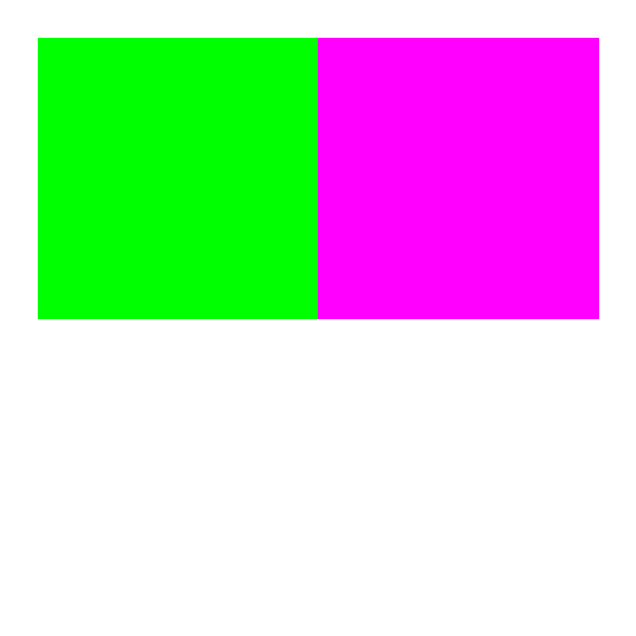

In [ ]:
# Generate a color map
colors = distinctipy.get_colors(len(class_names))
int_colors = [tuple(int(c*255) for c in color) for color in colors]
distinctipy.color_swatch(colors)

In [ ]:
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [ ]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

Image Dims: (480, 640)


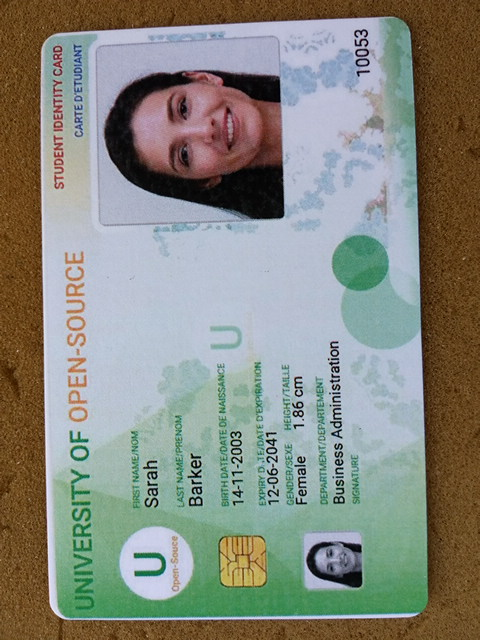

In [ ]:
# Load the sample image
file_id = list(img_dict.keys())[20]
sample_img = Image.open(img_dict[file_id]).convert('RGB')

print(f"Image Dims: {sample_img.size}")
sample_img

In [ ]:
annotation_df.loc[file_id].to_frame()

10053
version                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         3.21.1
flags                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               {}
shapes       [{'label': 'student_id', 'line_color': None, 'fill_color': None, 'points': [[43.95238095238096, 41.904761904761905], [51.571428571428555, 36.19047619047619], [391.57142857142856, 17.142857142857142], [405.8571428571428, 23.80952380952381], [411.57142857142856, 50.476190476190474], [427.7619047619047, 601.9047619047619], [423.0, 612.3809523809524], [399.19047619047615, 613.3333333333333], [108.71428571428572, 618.0952380952381], [75.38095238095235, 618.0952380952381], [63.95238095238096, 617.1428571428571], [58.23809523809524, 607.6190476190476], [43.0, 217.14285714285714], [43.0, 60.0]], 'shape_type': 'polygon', 'flags': {}}]
lineColor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [0, 255, 0, 128]
fillColor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [255, 0, 0, 128]
imagePath                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    10053.jpg
imageData                                                                                                       

### Define a function to convert segmentation polygons to images

In [ ]:
def create_polygon_mask(image_size, vertices):
    mask_img = Image.new('L', image_size, 0)
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    return mask_img

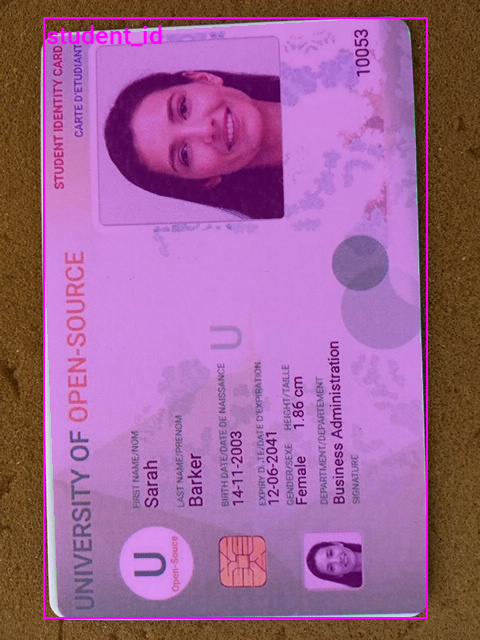

In [ ]:
# Annotate sample image
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
bboxes = torchvision.ops.masks_to_boxes(masks)

annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=bboxes,
    labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

### Loading the Mask R-CNN Model

In [ ]:
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

model.to(device=device, dtype=dtype);

model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

In [ ]:
# Summarizing the Model
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/usr/local/lib/python3.10/dist-packages/torchtnt/utils/module_summary.py:263: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs
0  MaskRCNN       45.9 M                 45.7 M        183 M         331 G

### Preparing the Data

In [ ]:
img_keys = list(img_dict.keys())

random.shuffle(img_keys)

train_pct = 0.8
val_pct = 0.2

train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

In [ ]:
# Set training image size
train_sz = 512

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=1.0,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)

In [ ]:
resize_max = ResizeMax(max_sz=train_sz)
pad_square = PadSquare(shift=True, fill=0)

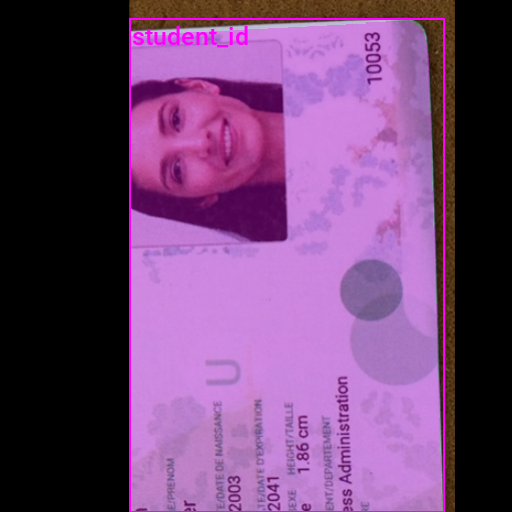

In [ ]:
# Test the transforms
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
xy_coords = [[tuple(p) for p in points] for points in shape_points]
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])

sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

targets = {
    'masks': Mask(masks),
    'boxes': bboxes,
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

cropped_img, targets = iou_crop(sample_img, targets)

resized_img, targets = resize_max(cropped_img, targets)

padded_img, targets = pad_square(resized_img, targets)

resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3,
    colors=sample_colors
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']],
    colors=sample_colors
)

display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [ ]:
class StudentIDDataset(Dataset):
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        super(Dataset, self).__init__()

        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        return len(self._img_keys)

    def __getitem__(self, index):
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)

        if self._transforms:
            image, target = self._transforms(image, target)

        return image, target

    def _load_image_and_target(self, annotation):
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')

        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [create_polygon_mask(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])

        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}

In [ ]:
# Image Transforms
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

In [ ]:
# Initialize Datasets
class_to_idx = {c: i for i, c in enumerate(class_names)}

train_dataset = StudentIDDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = StudentIDDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

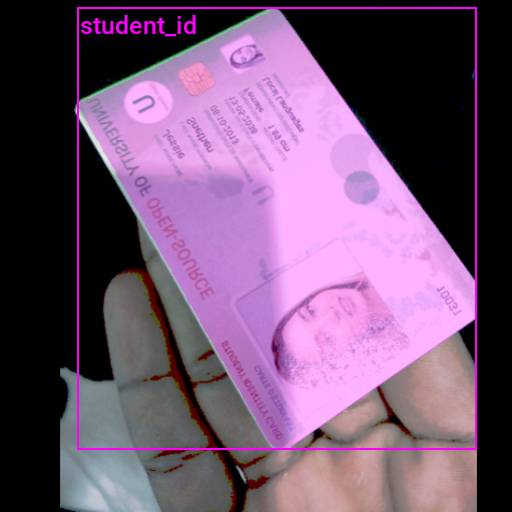

In [ ]:
# Inspect Samples
dataset_sample = train_dataset[2]

sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

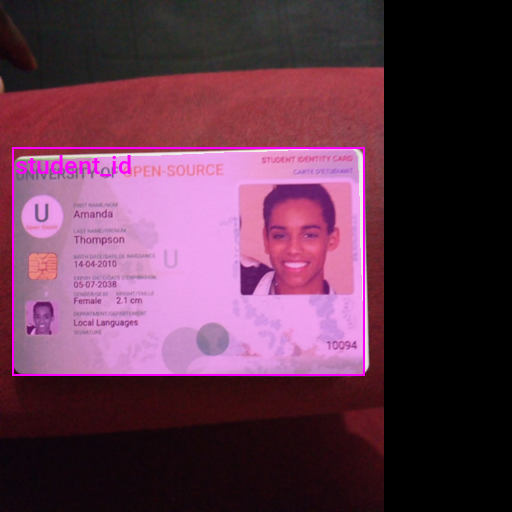

In [ ]:
# Inspect validation set sample
dataset_sample = valid_dataset[0]

sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)

annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

In [ ]:
# Initialize DataLoaders
bs = 4

num_workers = multiprocessing.cpu_count()//2

data_loader_params = {
    'batch_size': bs,
    'num_workers': num_workers,
    'pin_memory': 'cuda' in device,
    'pin_memory_device': device if 'cuda' in device else '',
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

### Fine-tuning the Model

In [ ]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    model.train()

    epoch_loss = 0
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    for batch_id, (inputs, targets) in enumerate(dataloader):
        inputs = torch.stack(inputs).to(device)

        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item

        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()

    return epoch_loss / (batch_id + 1)

In [ ]:
def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):

    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

In [ ]:
# Set the Model Checkpoint Path
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

checkpoint_dir = Path(project_dir/f"{timestamp}")

checkpoint_dir.mkdir(parents=True, exist_ok=True)

checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-mask-r-cnn/2024-12-22_07-06-12/maskrcnn_resnet50_fpn_v2.pth


In [ ]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

pytorch-mask-r-cnn/2024-12-22_07-06-12/student-id-colormap.json


In [ ]:
lr = 5e-4

epochs = 40

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

<ipython-input-58-e598ec374289>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/30 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

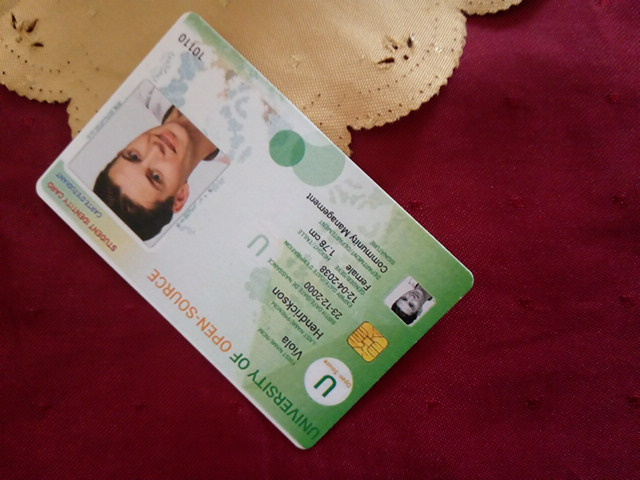

In [ ]:
file_id = random.choice(val_keys)

test_file = img_dict[file_id]

test_img = Image.open(test_file).convert('RGB')

input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

In [ ]:
# Get the target annotation data
target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

In [ ]:
# Pass the input data to the model
model.eval();

model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

with torch.no_grad():
    model_output = model(input_tensor)

In [ ]:
# Filter the model output
threshold = 0.5

model_output = move_data_to_device(model_output, 'cpu')

scores_mask = model_output[0]['scores'] > threshold

pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

pred_scores = model_output[0]['scores']

pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

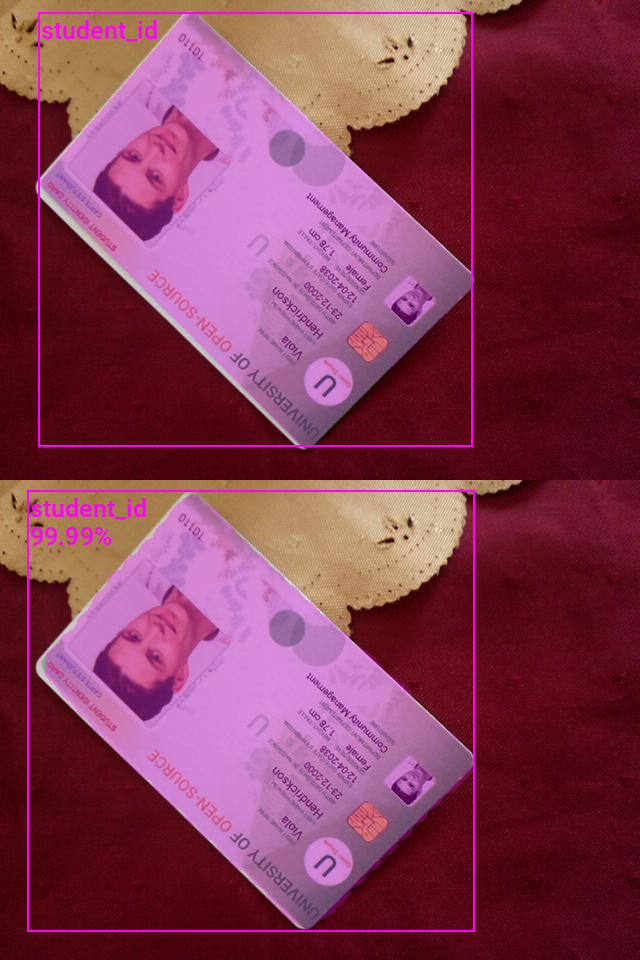

In [ ]:
# Annotate the image using the model predictions
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

img_tensor = transforms.PILToTensor()(test_img)

annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
annotated_test_img = tensor_to_pil(annotated_tensor)

annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')